# **Table Of Contents**
1. Problem Statement and Research Question
2. Explore and Visulize Data
3. Baseline Models (Logit Reg and Random Forest)
4. Interpreting Models and Results
5. Final Model Pipeline

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Problem Statement and Research Question**

**Question:** Can New York Times headlines provide us with information that we can use to predict changes in the S&P 500?

**Description:** Using various sentiment analysis methods (VADER and TextBlob), we computed a score for each NYT headline (2.1 million). Each headline a date and section feild as well. NYT headlines were collected from 1990 to 2020 (avoiding harder to predict post-COVID fluctuations in the market). Subsequent S&P 500 data closing prices have been collected at each time period during this timeframe, and we scaled these values to inflation.

**Approach:** To do this, we created a dataframe with an entry for each time point. For that time point, we average the sentiment scores for that day, and also add the number of headlines from each section into the row. Finally, our response is the S&P 500 closing price.

For the sentiment analysis, we used two different methods - VADER and TextBlob - to give a score to each NYT article headline. Due to the short nature of each headline (on average 6 words or less), the majority of scores are 0, thus we exclude sentiment scores of 0 in order to assess either a positive or negative value for the time period - we will experiment with this threshold. Finally, the timepoints we are testing will be day, week, month, and year. This means we have a df where each row is a day date (averaged sentiment scores for that day and S&P closing price for that day), week (averaged sentiment scores for that day and averaged S&P closing price for that week) and so on.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>


# **Explore and Visulize Data**

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.cm as cm
import numpy as np
# from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import linregress

In our previous milestone 3, we created 4 dataframes each for 1 day, 1 week, 1 month, and 1 year time points. In the file, we also updated this code to separate our headlines into a train / test split of 15%. To do this, the 15% of headlines per day were randomly selected to create a day/week/month/year test df with all the same features as the train dfs. In total, we have 8 dataframes found in the **df_train_test** folder, each separated as descried in the pervious molestone file.

### File Description Post Cleaning

1. __daily_test.xlsx & daily_train.xlsx__
    Average sentiment of the day's headlines, and number of headlines in each section for that date. Closing price for the day.
3. __weekly_test.xlsx & weekly_train.xlsx__
    Average sentiment of the week's headlines, and number of headlines in each section for that week. Average closing price for the week.
3. __monthly_test.xlsx & monthly_train.xlsx__
    Average sentiment of the months's headlines, and number of headlines in each section for that month. Average closing price for the month.
4. __yearly_test.xlsx & yearly_train.xlsx__
    Average sentiment of the year's headlines, and number of headlines in each section for that year. Average closing price for the year.

In [73]:
# Load in files from the folder which were saved from milestone 3 (train test split 15%)
daily_train = pd.read_excel("df_train_test/daily_train.xlsx", index_col=0)
weekly_train = pd.read_excel("df_train_test/weekly_train.xlsx", index_col=0)
monthly_train = pd.read_excel("df_train_test/monthly_train.xlsx", index_col=0)
yearly_train = pd.read_excel("df_train_test/yearly_train.xlsx", index_col=0)

daily_test = pd.read_excel("df_train_test/daily_test.xlsx", index_col=0)
weekly_test = pd.read_excel("df_train_test/weekly_test.xlsx", index_col=0)
monthly_test = pd.read_excel("df_train_test/monthly_test.xlsx", index_col=0)
yearly_test = pd.read_excel("df_train_test/yearly_test.xlsx", index_col=0)


We will scale all the computed values from -1 to 1 to best visulize our results. We will do this for VADER and TextBlob (both with and without zero values), percent change, and closing price.

In [74]:
# -1 to 1 scaling
def scale_column(data, column):
    min_val = data[column].min()
    max_val = data[column].max()
    data[f"{column}_scaled"] = 2 * (data[column] - min_val) / (max_val - min_val) - 1

datasets = [daily_train, daily_test, weekly_train, weekly_test, monthly_train, monthly_test, yearly_train, yearly_test]
columns_to_scale = [ "sentiment_score_VADER", "score_textblob", "sentiment_score_VADER_nonzero", "score_textblob_nonzero", "Inflation_Adjusted_Close", "Pct_Change" ]

for df in datasets:
    for col in columns_to_scale:
        if col in df.columns:
            scale_column(df, col)

In [75]:
# Just to check that all train files have same colums, and also to look at them.
daily_columns = set(daily_train.columns)
all_same_columns = (
    daily_columns == set(weekly_train.columns) ==
    set(monthly_train.columns) ==
    set(yearly_train.columns)
)

print("Columns in each of the dataframes shown below:")
display(daily_columns)
print("\nChecking that all the colums are consistent across the dataframes: ")
print(all_same_columns)

Columns in each of the dataframes shown below:


{'Admin',
 'Archives',
 'Arts',
 'At Home',
 'Automobiles',
 'Blogs',
 'Books',
 'Booming',
 'Briefing',
 'Burst',
 'Business Day',
 'Climate',
 'College',
 'Corrections',
 "Critic's Choice",
 'Crosswords & Games',
 'Editors Picks',
 'Education',
 'Fashion & Style',
 'Feeds',
 'Food',
 'Giving',
 'Global Home',
 'Great Homes & Destinations',
 'Guides',
 'Health',
 'Home & Garden',
 'Homepage',
 'Inflation_Adjusted_Close',
 'Inflation_Adjusted_Close_scaled',
 'International Home',
 'Job Market',
 'Lens',
 'Magazine',
 'Movies',
 'Multimedia/Photos',
 'NYT Now',
 'Neediest Cases',
 'New York',
 'Obituaries',
 'Open',
 'Opinion',
 'Parenting',
 'Pct_Change',
 'Pct_Change_scaled',
 'Podcasts',
 'Public Editor',
 'Reader Center',
 'Real Estate',
 'Science',
 'Slideshows',
 'Smarter Living',
 'Sports',
 'Style',
 'Sunday Review',
 'T Brand',
 'T Magazine',
 'Technology',
 'The Learning Network',
 'The Upshot',
 'The Weekly',
 'Theater',
 'Times Insider',
 'Times Topics',
 'Today’s Paper',
 '


Checking that all the colums are consistent across the dataframes: 
True


Now, we can do EDA to explore the best time frame (D, W, M, Y) and also analyze and sentiment analysis method might be best. To do this, let's make a plot of all the different combinations of Sentiemnt analysis Vs. Closing Price and Sentiemnt analysis Vs. Percent Change

In [76]:
def plot_sentiment_subplots(data_dict, sentiment_column, close_column, title_prefix, nonzero=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(f"{title_prefix} Sentiment vs. Normalized Closing Price", fontsize=16)

    for ax, (freq, data) in zip(axes.flat, data_dict.items()):
        filtered_data = data if not nonzero else data[data[sentiment_column] != 0]

        years = filtered_data.index.year
        cmap = cm.get_cmap("viridis")
        norm = plt.Normalize(years.min(), years.max())
        colors = cmap(norm(years))

        ax.scatter(filtered_data[sentiment_column], filtered_data[close_column], c=colors, alpha=0.6)
        ax.set_title(f"{freq.capitalize()} Data", fontsize=14)
        ax.set_xlabel(sentiment_column, fontsize=12)
        ax.set_ylabel(close_column, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

def plot_sentiment_vs_pct_change(data_dict, sentiment_column, pct_column, title_prefix, nonzero=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(f"{title_prefix} Sentiment vs. Percent Change", fontsize=16)

    for ax, (freq, data) in zip(axes.flat, data_dict.items()):
        filtered_data = data if not nonzero else data[data[sentiment_column] != 0]

        years = filtered_data.index.year
        cmap = cm.get_cmap("viridis")
        norm = plt.Normalize(years.min(), years.max())
        colors = cmap(norm(years))

        ax.scatter(filtered_data[sentiment_column], filtered_data[pct_column], c=colors, alpha=0.6)
        ax.set_title(f"{freq.capitalize()} Data", fontsize=14)
        ax.set_xlabel(sentiment_column, fontsize=12)
        ax.set_ylabel(pct_column, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

data_dict = {"Daily": daily_train, "Weekly": weekly_train, "Monthly": monthly_train, "Yearly": yearly_train}


### Sentiment Score (Both VADER and TextBlob) vs. Closing Price and Percent Change

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_86417/181240400.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


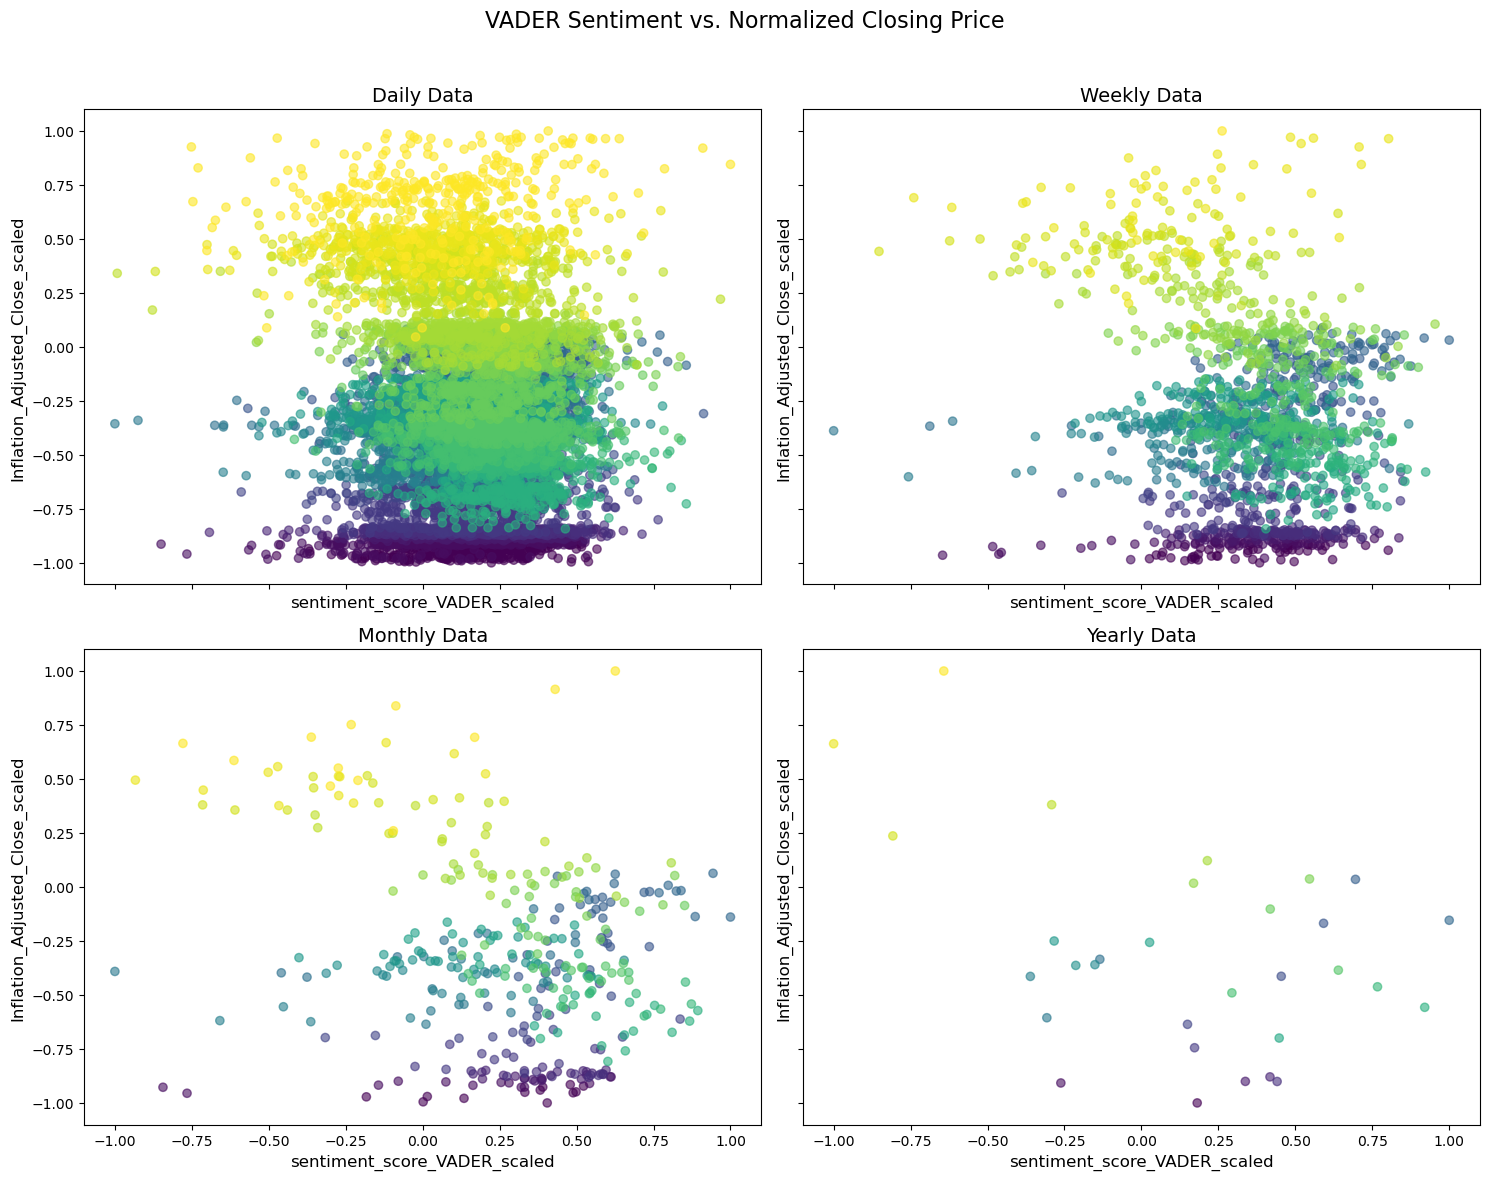

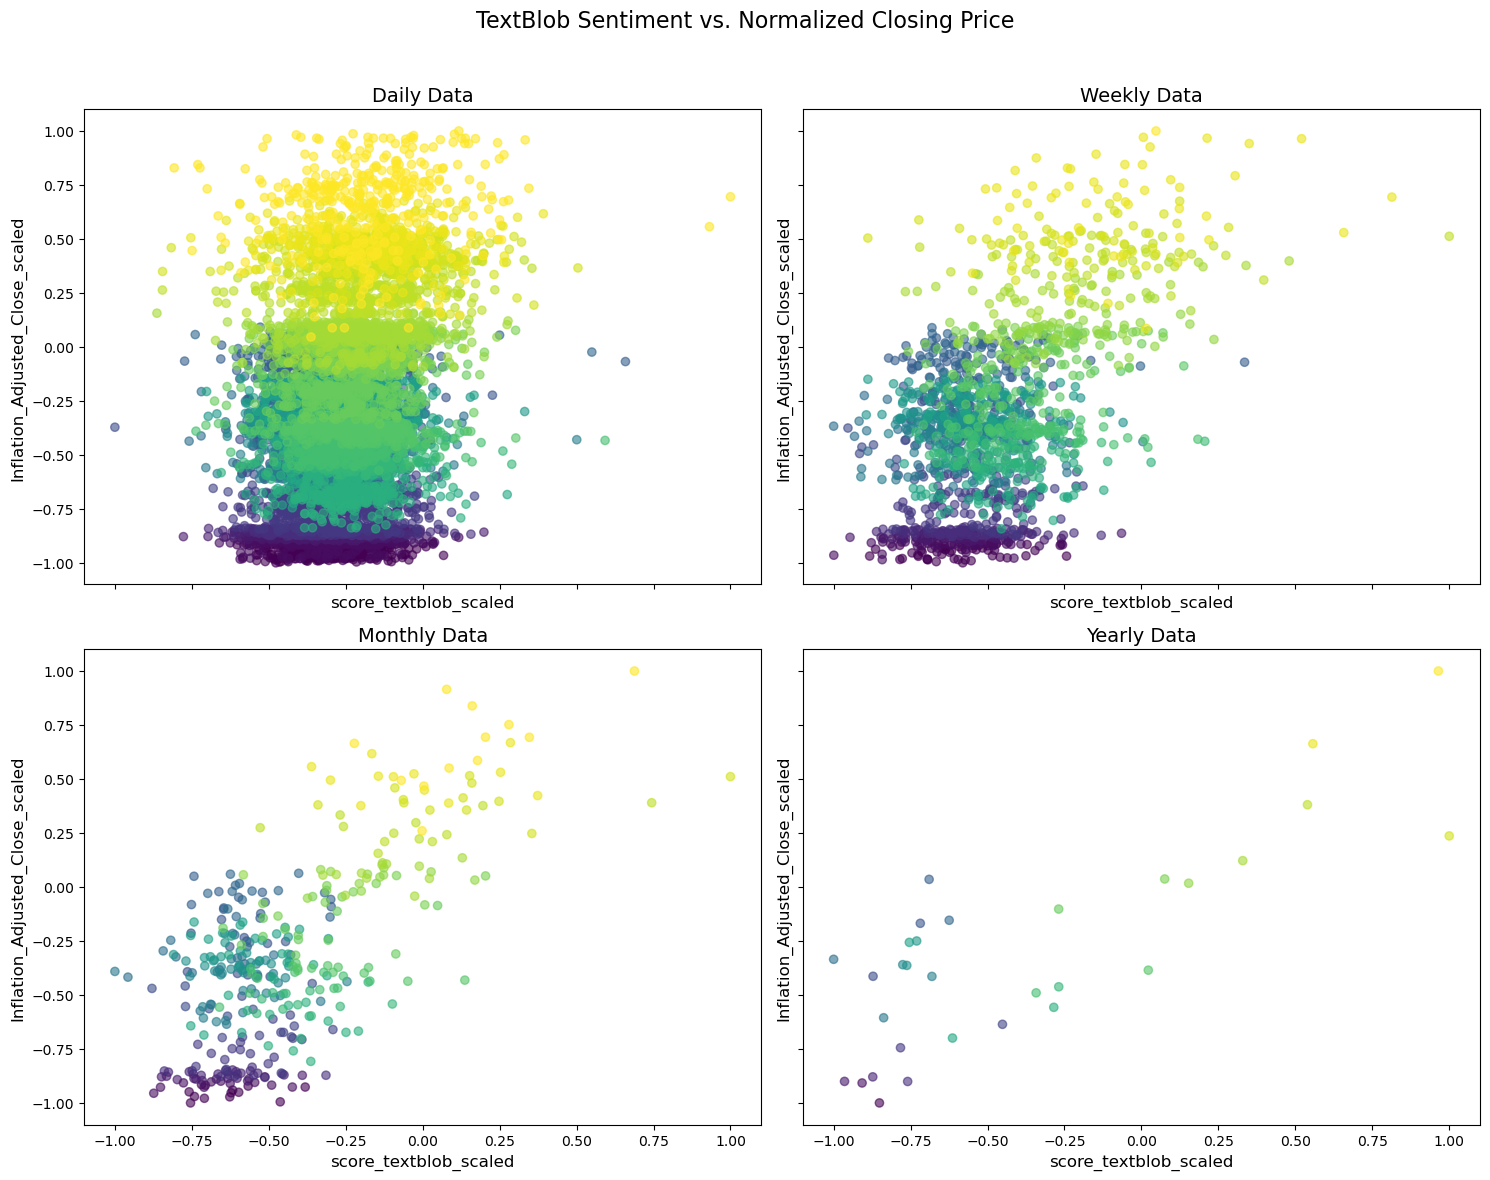

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_86417/181240400.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


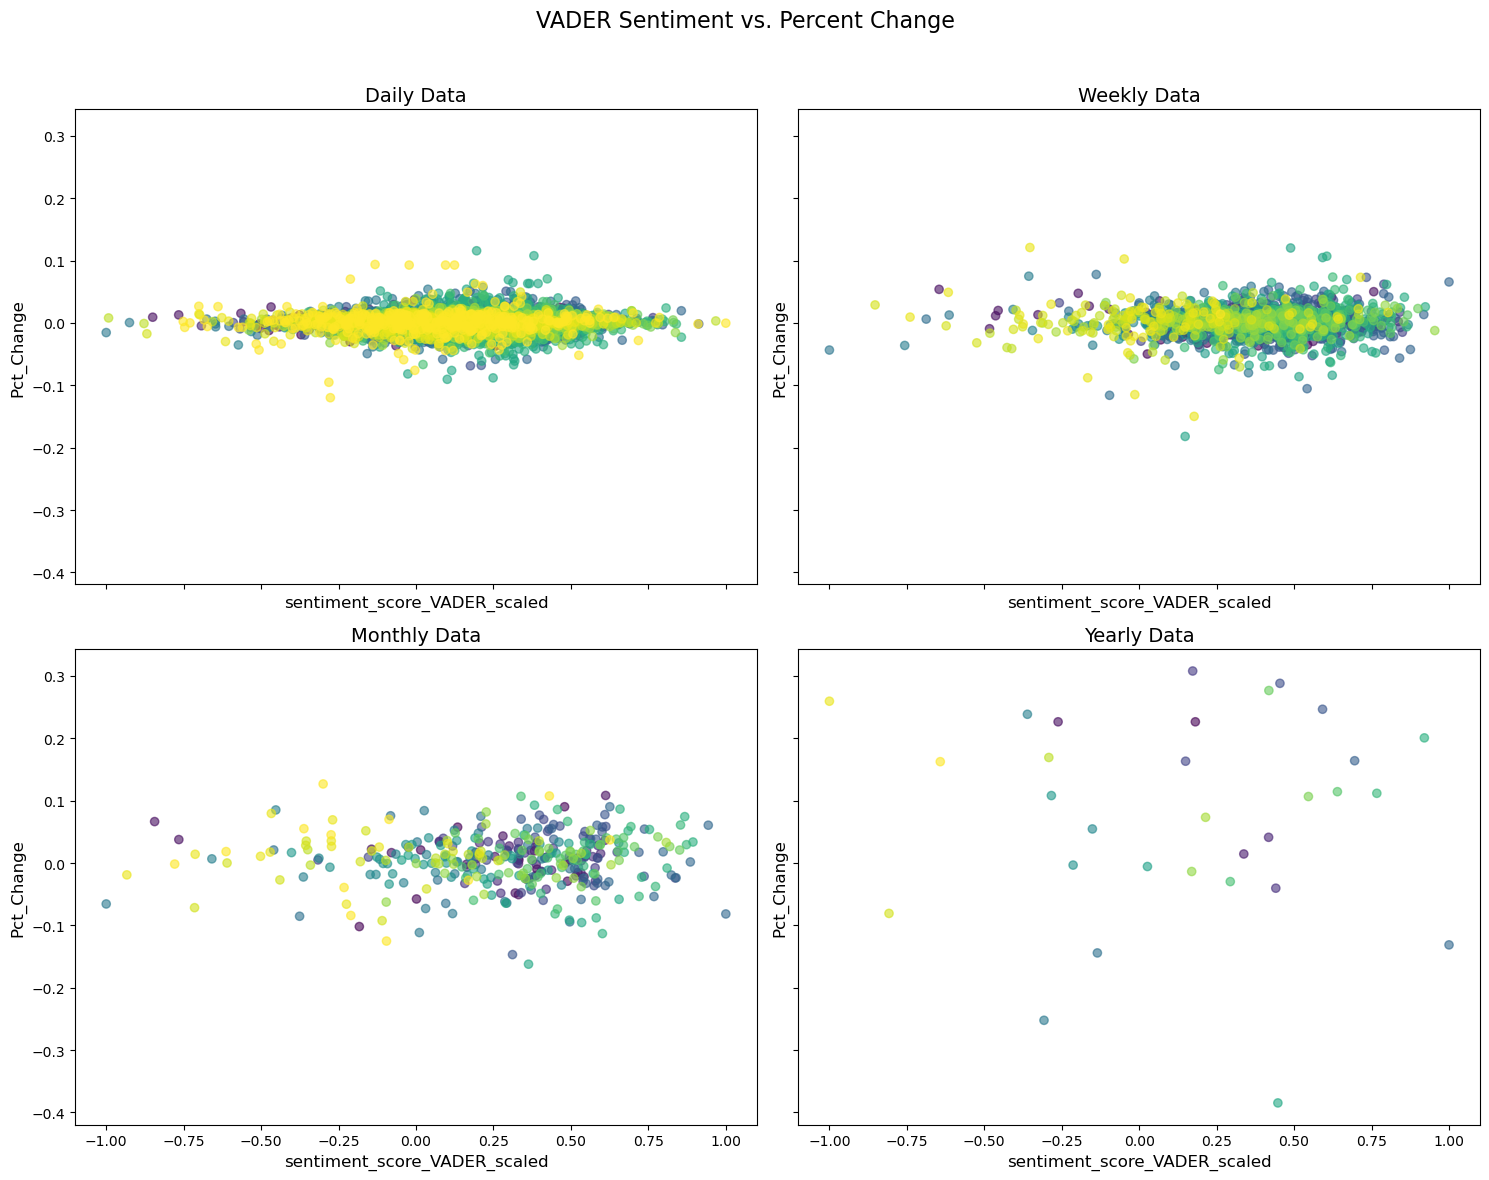

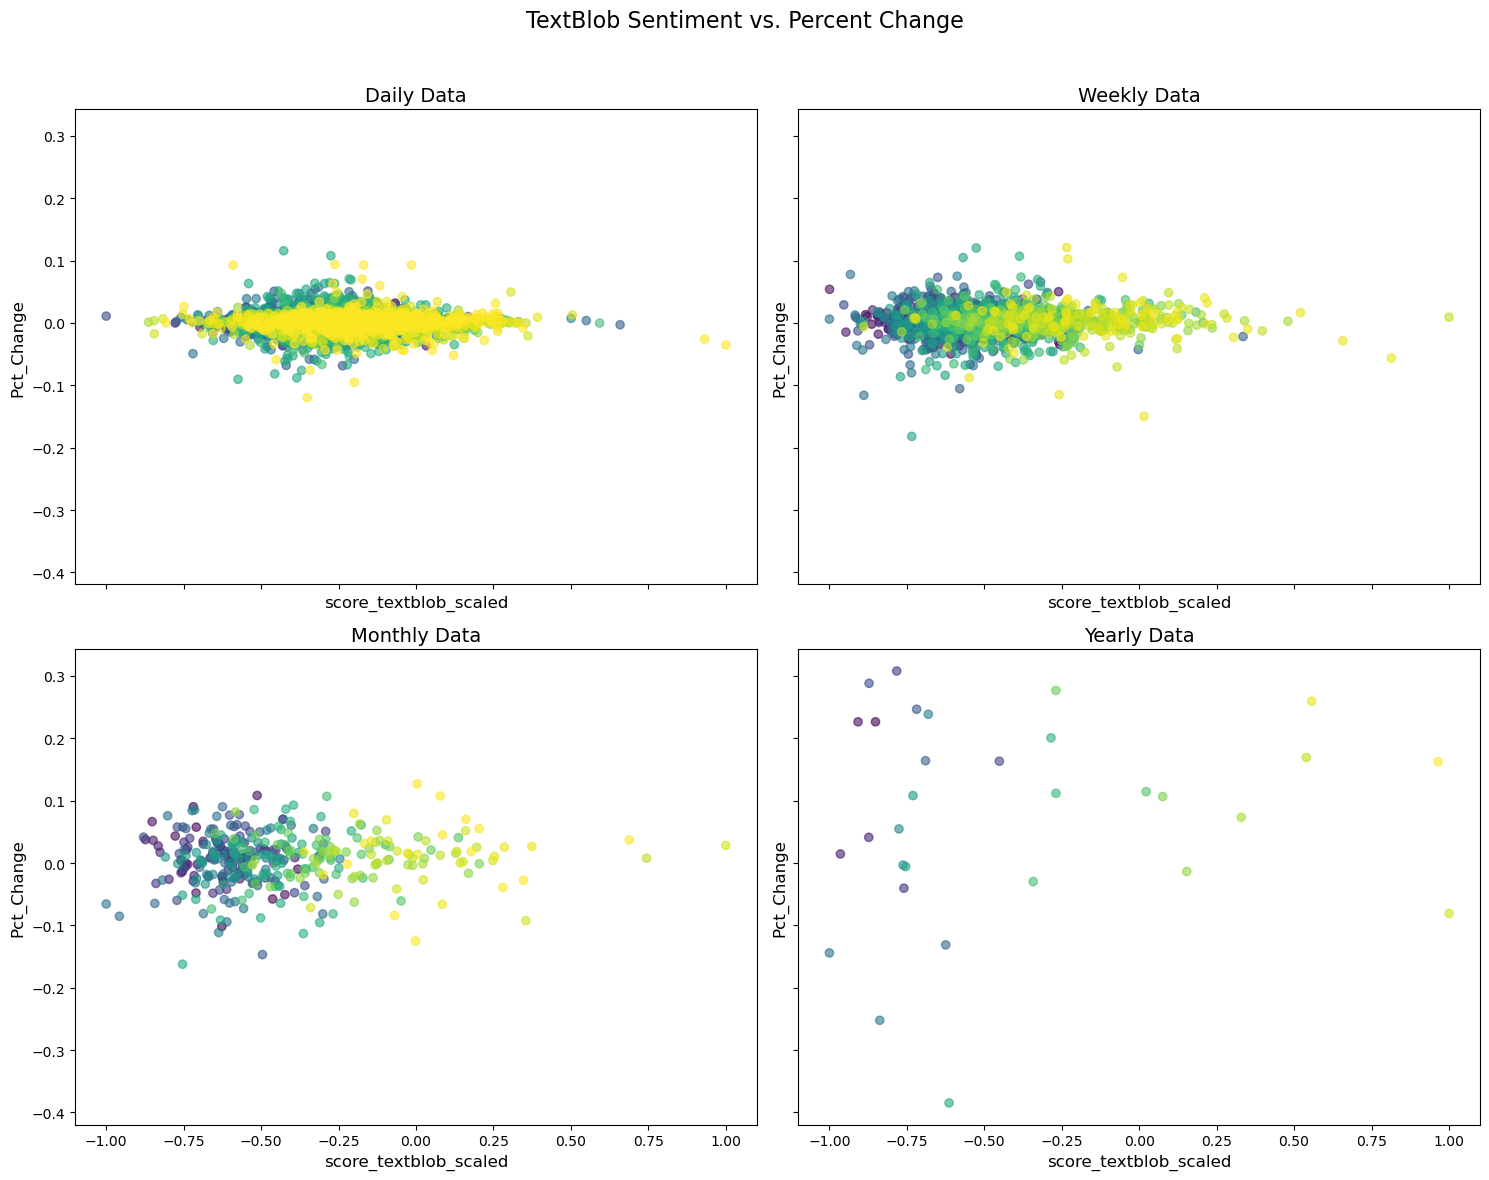

In [77]:
plot_sentiment_subplots(data_dict, 'sentiment_score_VADER_scaled', 'Inflation_Adjusted_Close_scaled', "VADER", nonzero=False)
plot_sentiment_subplots(data_dict, 'score_textblob_scaled', 'Inflation_Adjusted_Close_scaled', "TextBlob", nonzero=False)

plot_sentiment_vs_pct_change(data_dict, 'sentiment_score_VADER_scaled', 'Pct_Change', "VADER", nonzero=False)
plot_sentiment_vs_pct_change(data_dict, 'score_textblob_scaled', 'Pct_Change', "TextBlob", nonzero=False)

### Sentiment Score (Both VADER and TextBlob excluding nonzero scores) vs. Closing Price and Percent Change

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_86417/181240400.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


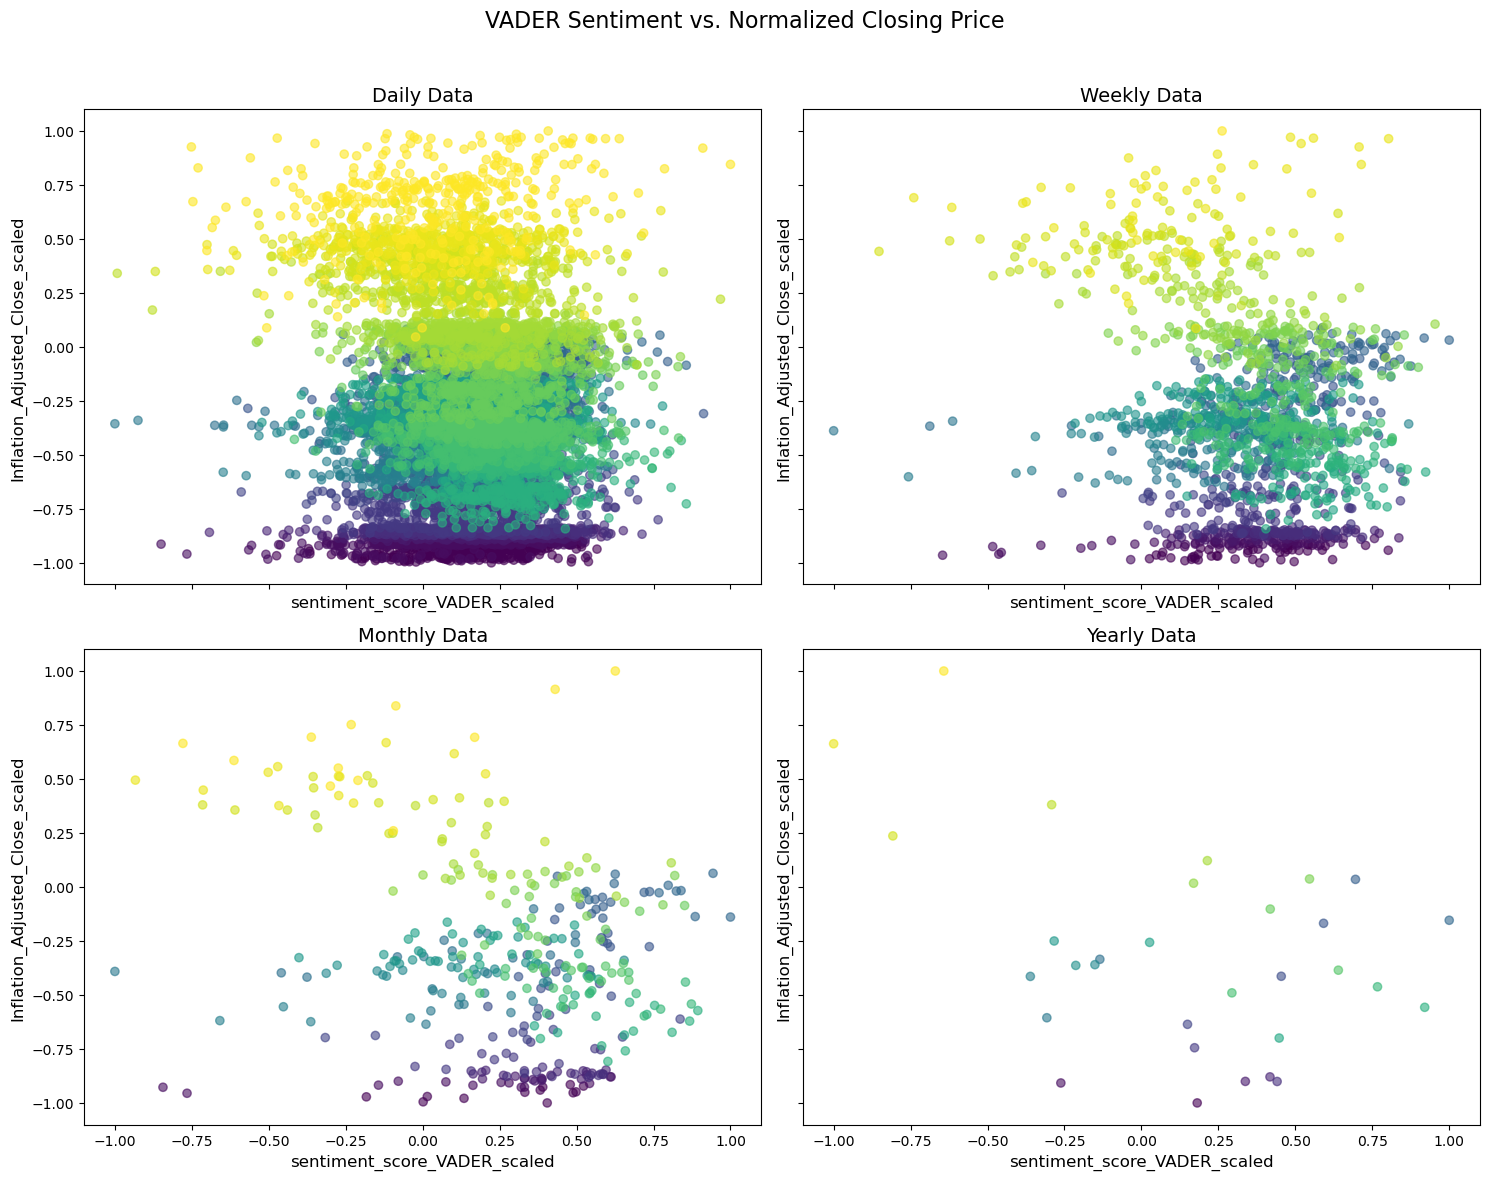

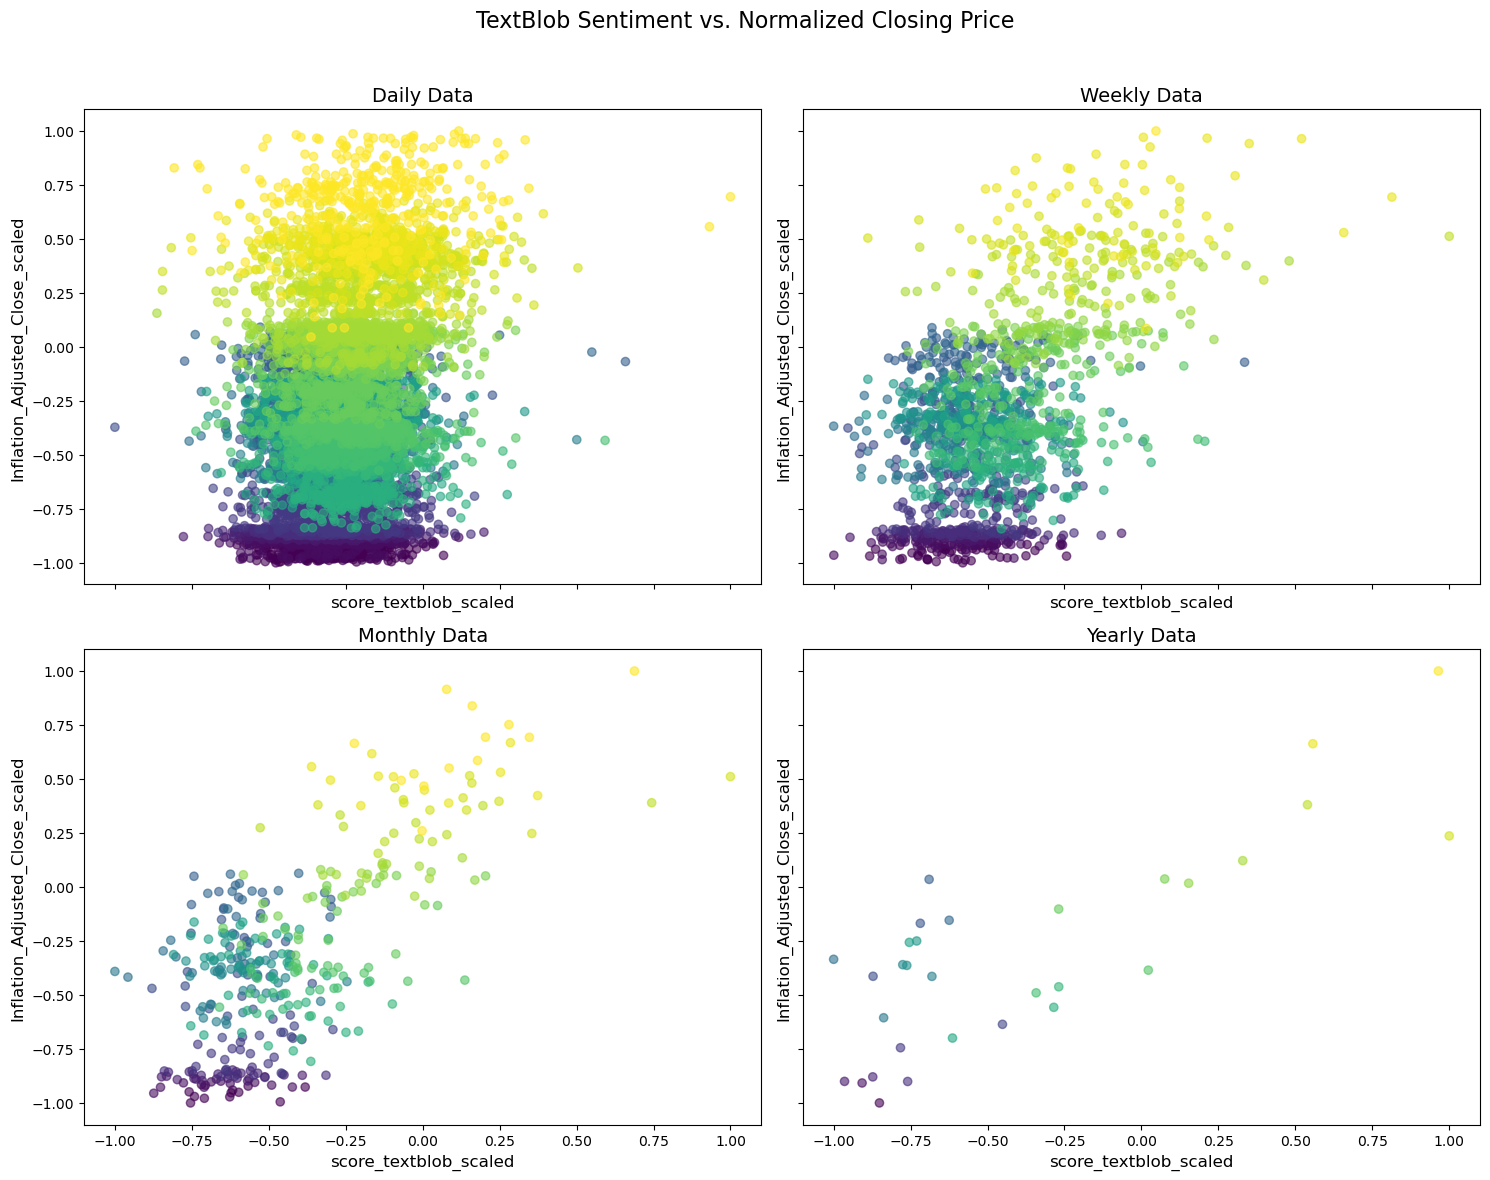

/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_86417/181240400.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


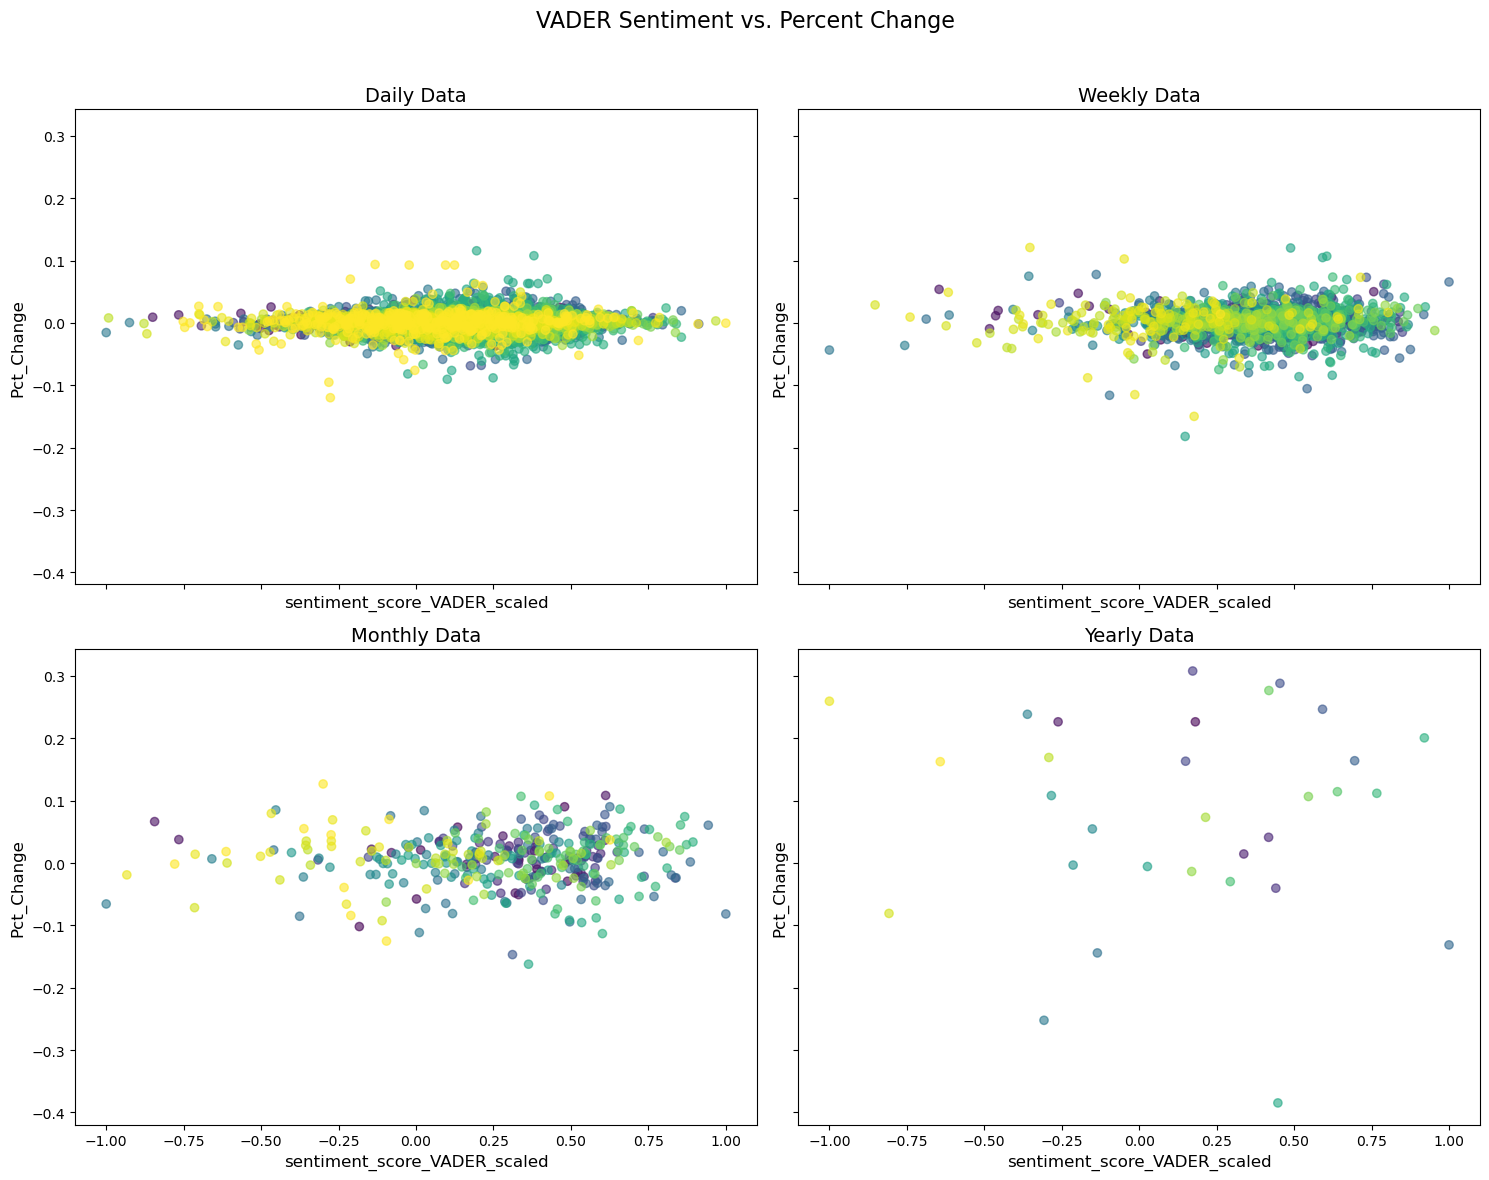

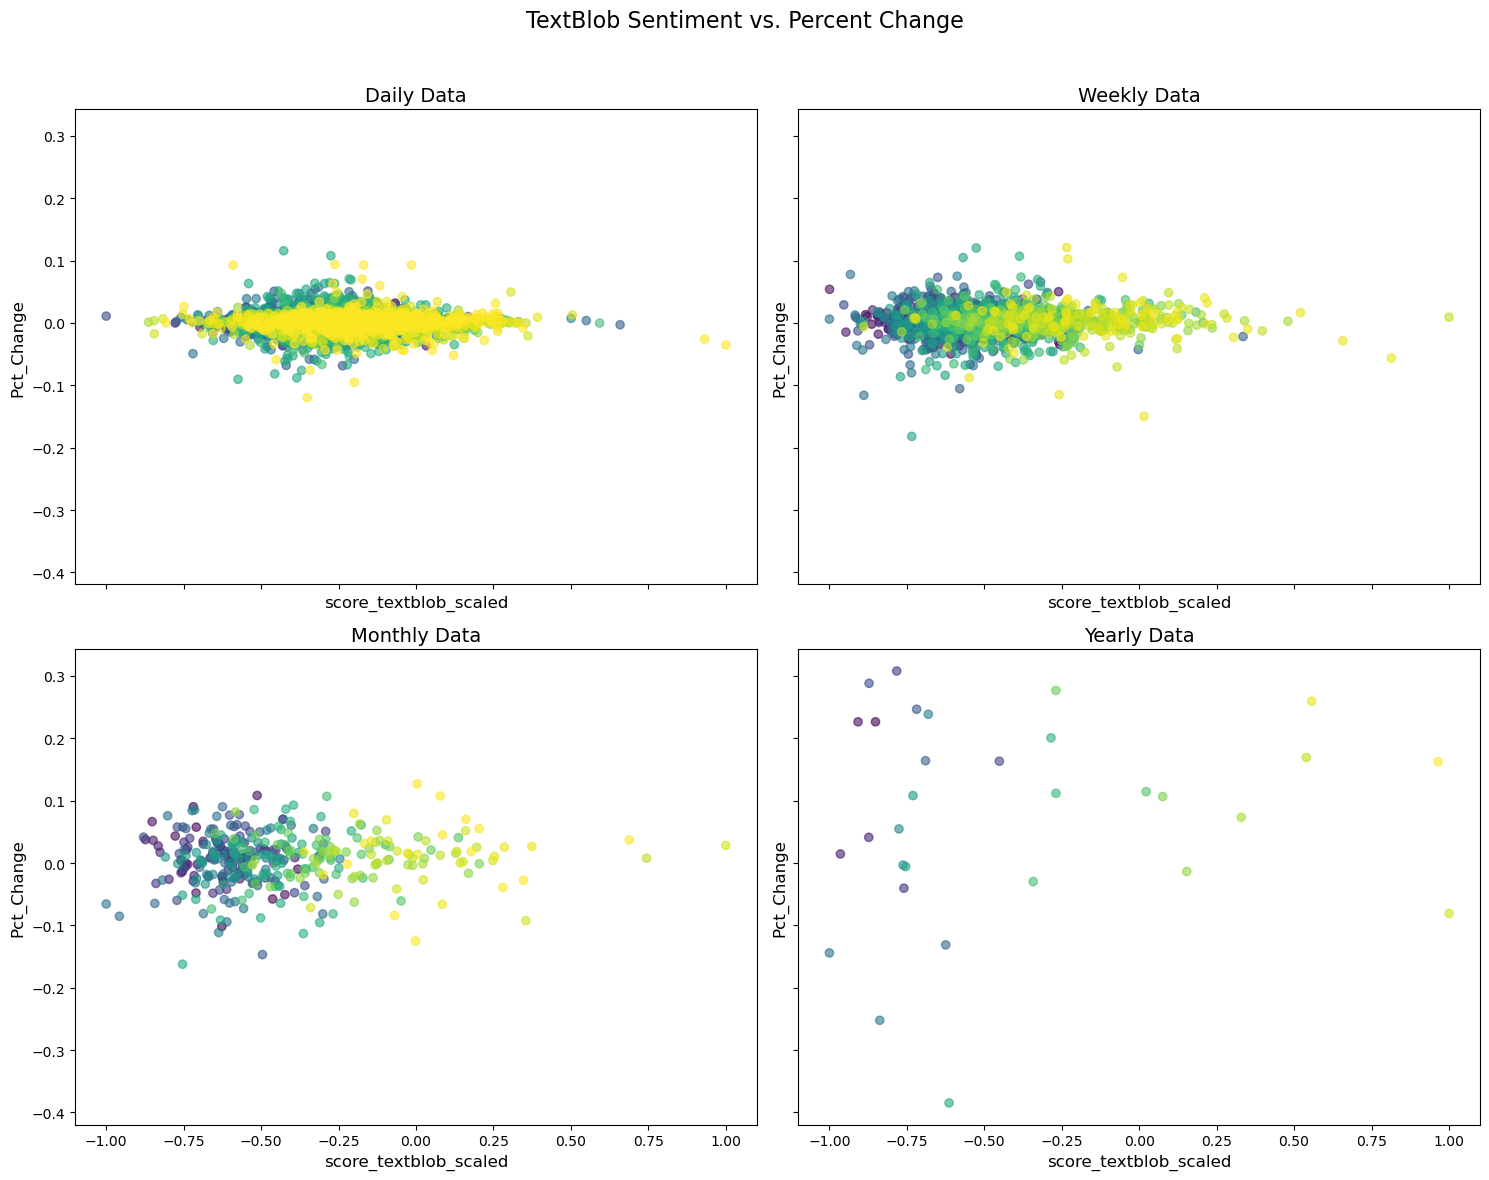

In [78]:
plot_sentiment_subplots(data_dict, 'sentiment_score_VADER_scaled', 'Inflation_Adjusted_Close_scaled', "VADER", nonzero=True)
plot_sentiment_subplots(data_dict, 'score_textblob_scaled', 'Inflation_Adjusted_Close_scaled', "TextBlob", nonzero=True)

plot_sentiment_vs_pct_change(data_dict, 'sentiment_score_VADER_scaled', 'Pct_Change', "VADER", nonzero=True)
plot_sentiment_vs_pct_change(data_dict, 'score_textblob_scaled', 'Pct_Change', "TextBlob", nonzero=True)

**EDA analysis:** It appears that 

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>


# **Baseline Models**

## 1. Logistic Regression

## 2. Linear Regression

## 3. Random Forest

Worst case  - if our model cant predict changes in changes numerically, we could say if they are going to go up or down from pervious time point with logistic regression

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Interpreting Models and Results**

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Final Model Pipeline**